In [2]:
import os
import h5py
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Flatten, Dense, Dropout, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

tf.compat.v1.disable_eager_execution()

In [3]:
with h5py.File(os.getcwd() + '/data/dataset_itop.hdf5', 'r') as hf:
    x_train = np.asarray(hf['x_train'])
    y_train = np.asarray(hf['y_train'])
    x_test  = np.asarray(hf['x_test'])
    y_test  = np.asarray(hf['y_test'])
    
train_size, img_w, img_h = x_train.shape
test_size, j_type, j_coord = y_test.shape

x_train = np.reshape(x_train, (train_size, img_w, img_h, 1))
x_test  = np.reshape(x_test,  (test_size,  img_w, img_h, 1))

y_train = np.reshape(y_train, (train_size, j_type*j_coord, 1))
y_test  = np.reshape(y_test,  (test_size,  j_type*j_coord, 1))

print(x_train.shape)
print(y_train.shape)

(39795, 192, 112, 1)
(39795, 45, 1)


0.0
1.0


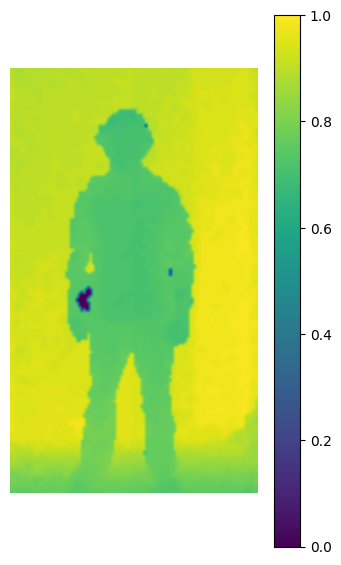

In [5]:
print(np.min(x_train[0]))
print(np.max(x_train[0]))

plt.matshow(x_train[0], cmap=plt.cm.viridis, interpolation='bicubic')
plt.colorbar()

plt.grid(visible=None)
plt.axis('off')
plt.show()

In [19]:
learning_rate = 0.001     #@param {type:"raw"}
num_epochs_to_train = 10  #@param {type:"integer"}
batch_size = 64           #@param {type:"integer"}
vector_dimension = 256    #@param {type:"integer"}

sampling_rate = 16000     #@param {type:"integer"}

In [36]:
def calculate_reconstruction_loss(y_target, y_predicted):
    error = y_target - y_predicted
    reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
    return reconstruction_loss

def _calculate_label_loss(y_target, y_predicted):
    error = y_target - y_predicted
    reconstruction_loss = K.mean(K.square(error), axis=0)
    return reconstruction_loss


def calculate_kl_loss(model):
    # functions takes the model as an argument
    # return a function which can take arbitrary number of args and return kl loss
    def _calculate_kl_loss(*args):
        kl_loss = -0.5 * K.sum(1 + model.log_variance - K.square(model.mu) -
                               K.exp(model.log_variance), axis=1)
        return kl_loss
    return _calculate_kl_loss

In [41]:
class VAE:
  def __init__(self,
               image_input,  #input layer for the image data
               label_input,  #input layer for the joint labels
               conv_filters, #convolutional network filters
               conv_kernels, #convNet kernel size
               conv_strides, #convNet strides
               latent_space_dim):
    self.image_input = image_input # (192, 112)
    self.label_input = label_input # (45, )
    self.conv_filters = conv_filters # is a list for each layer, i.e. [2, 4, 8]
    self.conv_kernels = conv_kernels # list of kernels per layer, [1, 2, 3]
    self.conv_strides = conv_strides # stride for each filter [1, 2, 2], note: 2 means you are downsampling the data in half
    self.latent_space_dim = latent_space_dim # how many neurons on bottleneck
    self.reconstruction_loss_weight = 100000

    self.encoder = None
    self.decoder = None
    self.model = None
    self.hist = None

    self.vae_output = None
    self.mlp_output = None

    self._num_conv_layers = len(conv_filters)
    self._shape_before_bottleneck = None
    self._model_output = None
    self._model_input = None

    self._build()

  def summary(self):
    self.encoder.summary()
    print("\n")
    self.decoder.summary()
    print("\n")
    self.model.summary()

  def _build(self):
    self._build_encoder()
    self._build_decoder()
    self._build_mlp()
    self._build_autoencoder()
    self._define_model_loss()

  def _define_model_loss(self):
    kl_loss = calculate_kl_loss(self)()
    reconstruction_loss = calculate_reconstruction_loss(self.image_input, self.vae_output)
    joint_estimation_loss = _calculate_label_loss(self.label_input, self.mlp_output)

    combined_loss = self.reconstruction_loss_weight*(reconstruction_loss + joint_estimation_loss) + kl_loss
    self.model.add_loss(combined_loss)
    self.model.add_metric(reconstruction_loss, name="reconstruction_loss", aggregation='mean')
    self.model.add_metric(joint_estimation_loss, name="joint_estimation_loss", aggregation='mean')
  
  def compile(self, learning_rate=0.0001):
    self.model.compile(optimizer=Adam(learning_rate=learning_rate))
  
  def train(self, x_train, y_train, batch_size, num_epochs):
    self.model.fit([x_train, y_train],
                  #  x_train,
                   batch_size=batch_size,
                   epochs=num_epochs,
                   shuffle=True)

  #----------------FULL MODEL-----------------#
  def _build_autoencoder(self):
    model_input = self._model_input
    label_input = self.label_input
    self.vae_output = self.decoder(self.encoder(model_input))
    self.mlp_output = self.mlp(self.encoder(model_input))

    self.model = Model([model_input, label_input], [self.vae_output, self.mlp_output], name='autoencoder')

  #----------------MLP-----------------#
  def _build_mlp(self):
    mlp_input = self._add_mlp_input()
    mlp_output = self._add_mlp_layers(mlp_input)
    self.mlp = Model(mlp_input, mlp_output, name=f"MLP_model")

  def _add_mlp_input(self):
    return Input(shape=self.latent_space_dim, name="mlp_input")

  def _add_mlp_layers(self, mlp_input):
    num_neurons = np.prod(self._shape_before_bottleneck)
    d_layer = Dense(num_neurons, activation='relu', name="MLP_layer1")(mlp_input)
    o_layer = Dropout(0.45, name="MLP_dropout1")(d_layer)
    d_layer = Dense(512, activation='relu', name="MLP_layer2")(o_layer)
    o_layer = Dropout(0.45, name="MLP_dropout2")(d_layer)
    d_layer = Dense(45, activation='softmax', name="MLP_layer3")(o_layer)
    r_layer = Reshape((45, 1), name="MLP_reshape")(d_layer)
    return r_layer

  #----------------DECODER-----------------#
  def _build_decoder(self):
    decoder_input = self._add_decoder_input()
    dense_layer = self._add_dense_layer(decoder_input)
    reshape_layer = self._add_reshape_layer(dense_layer)
    conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
    decoder_output = self._add_decoder_output(conv_transpose_layers)
    self.decoder = Model(decoder_input, decoder_output, name="decoder")
    self._model_output = self.decoder(self.encoder(self._model_input))

  def _add_decoder_input(self):
    return Input(shape=self.latent_space_dim, name="decoder_input")

  def _add_dense_layer(self, decoder_input):
    num_neurons = np.prod(self._shape_before_bottleneck) # [ 1, 2, 4] -> 8
    dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
    return dense_layer

  def _add_reshape_layer(self, dense_layer):
    return Reshape(self._shape_before_bottleneck)(dense_layer)

  def _add_conv_transpose_layers(self, x):
    for layer_index in reversed(range(1, self._num_conv_layers)):
      x = self._add_conv_transpose_layer(layer_index, x)
    return x

  def _add_conv_transpose_layer(self, layer_index, x):
    layer_num = self._num_conv_layers - layer_index
    conv_transpose_layer = Conv2DTranspose(
        filters=self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        activation='relu',
        padding = "same",
        name=f"decoder_conv_transpose_layer_{layer_num}"
    )
    x = conv_transpose_layer(x)
    x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
    return x

  def _add_decoder_output(self, x):
    conv_transpose_layer = Conv2DTranspose(
        filters = 1,
        kernel_size = self.conv_kernels[0],
        strides = self.conv_strides[0],
        padding = "same",
        name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
    )
    x = conv_transpose_layer(x)
    output_layer = Activation("sigmoid", name="sigmoid_output_layer")(x)
    return output_layer

  #----------------ENCODER-----------------#
  def _build_encoder(self):
    encoder_input = self.image_input
    conv_layers = self._add_conv_layers(encoder_input)
    bottleneck =  self._add_bottleneck(conv_layers)
    self._model_input = encoder_input
    self.encoder = Model(encoder_input, bottleneck, name="encoder")

  def _add_conv_layers(self, encoder_input):
    """Creates all convolutional blocks in encoder"""
    x = encoder_input
    for layer_index in range(self._num_conv_layers):
      x = self._add_conv_layer(layer_index, x)
    return x
  
  def _add_conv_layer(self, layer_index, x):
    """
    Adds a convolutional block to a graph of layers, consisting
    of Conv 2d + ReLu activation + batch normalization.
    """
    layer_number = layer_index + 1
    conv_layer = Conv2D(
        filters= self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        activation='relu',
        padding = "same",
        name = f"encoder_conv_layer_{layer_number}"
    )
    x = conv_layer(x)
    x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
    return x

  #-------------LATTENT SPACE-------------#
  def _add_bottleneck(self, x):
    """Flatten data and add bottleneck with Gaussian sampling (Dense layer)"""
    self._shape_before_bottleneck = K.int_shape(x)[1:]
    x = Flatten()(x)
    self.mu = Dense(self.latent_space_dim,name="mu")(x)
    self.log_variance = Dense(self.latent_space_dim,
                              name="log_variance")(x)
    
    def sample_point_from_normal_distribution(args):
      mu, log_variance = args
      epsilon = K.random_normal(shape=K.shape(self.mu), mean=0., stddev=1.)
      sampled_point = mu + K.exp(log_variance / 2) * epsilon

      return sampled_point

    x = Lambda(sample_point_from_normal_distribution, 
              name="encoder_output")([self.mu, self.log_variance])
    return x

In [42]:
label_input = Input(shape=(45, 1), name='label_input')
image_input = Input(shape=(192, 112, 1), name='image_input')

vae = VAE(label_input = label_input,
          image_input = image_input,
          conv_filters=(128, 64, 32, 16), 
          conv_kernels=(3, 3, 3, 3), 
          conv_strides=(2, 2, 2, (2,1)), 
          latent_space_dim = vector_dimension
          )

# vae.encoder.summary()
# vae.decoder.summary()
print(vae.model.count_params())
# tf.keras.utils.plot_model(vae.model, expand_nested=True, show_shapes=True)

4283854


In [ ]:
vae.compile(learning_rate)
vae.train(x_train, y_train, batch_size, num_epochs_to_train)

In [ ]:
loss = vae.hist.history['loss']
val_loss = vae.hist.history['val_loss']

epochs = range(num_epochs_to_train)

plt.figure()
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()